# Kaggle Competition: Titanic: Machine Learning from Disaster

### A start in Kaggle and DataScience Competitions

This is my first attemp to participate in a Kaggle Competetion. I'm studying datascience and machine learning for a few months, watching courses in Udemy, Youtube, Alura, and know it's time for test and put into practise some of the things that I've learned and most important: learn even more!

### Competetion description (directly from Kaggle)

"<i>The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.</i>"

### Imports 

Importing necessary (for now) packages for applying Data Science

In [403]:
import pandas as pd
import numpy as np

In [404]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Reading the csv files and checking the dataframe

Ok, now let's import the CSV files as dataframes, and take a look at how the data is structured

In [405]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [406]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### A function to transform the dataframe

Here is what I'm thinking: what about build a function, that is going to process the dataframe imported from the csv, to the dataframe that will be used for training and testing the model?

If all the transformations remain in the same function, it's going to be easier for loading a new dataset and train/test/predict it.

In [407]:
def transform_df(df):
    #do all the crazy stuff, magic, polymerizations with df
    df.drop(['PassengerId','Name','Ticket'], 1, inplace=True)
    
    # overwriting nan values with random age values (based on mean and standard deviation)
    age_mean = df['Age'].mean()
    age_std = df['Age'].std()
    age_nan_count = df['Age'].isnull().count()
    
    rand_ages = np.random.randint(age_mean - age_std, age_mean + age_std, age_nan_count)
    df['Age'][np.isnan(df['Age'])] = rand_ages
    
    #df['Age'] = pd.cut(df['Age'], bins=8)
    
    df.loc[df['Age'] < 10.367, 'Age'] = 0
    df.loc[(df['Age'] >= 10.367) & (df['Age'] < 20.315), 'Age'] = 1
    df.loc[(df['Age'] >= 20.315) & (df['Age'] < 30.263), 'Age'] = 2
    df.loc[(df['Age'] >= 30.263) & (df['Age'] < 40.21), 'Age'] = 3
    df.loc[(df['Age'] >= 40.21) & (df['Age'] < 50.157), 'Age'] = 4
    df.loc[(df['Age'] >= 50.157) & (df['Age'] < 60.105), 'Age'] = 5
    df.loc[(df['Age'] >= 60.105) & (df['Age'] < 70.0525), 'Age'] = 6
    df.loc[(df['Age'] >= 70.0525) & (df['Age'] < 80), 'Age'] = 7

    df['Age'] = df['Age'].astype(int)
    
    df['Family'] = df['SibSp'] + df['Parch']
    df.drop(['SibSp','Parch'], 1, inplace=True)

    df['Alone'] = df['Family'].copy()
    df['Alone'].loc[df['Alone'] > 0] = 1
    df['Alone'].loc[df['Alone'] == 0] = 0

    df.drop('Family', 1, inplace=True)
    
    embarked_most_common = df['Embarked'].value_counts().idxmax()
    df['Embarked'].fillna(embarked_most_common, inplace=True)
    
    df['Embarked'] = df['Embarked'].map({'S': 0, 'Q': 1, 'C': 2}).astype(int)
    
    df['Fare'].fillna(df['Fare'].dropna().median(), inplace=True)
    #df['Fare'] = pd.qcut(df['Fare'], 4)
    
    df.loc[df['Fare'] < 7.91, 'Fare'] = 0
    df.loc[(df['Fare'] >= 7.91) & (df['Fare'] < 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] >= 14.454) & (df['Fare'] < 31), 'Fare'] = 2
    df.loc[df['Fare'] >= 31, 'Fare'] = 3

    df['Fare'] = df['Fare'].astype(int)
    
    return df

Maybe that should be fine! But let's build this function little by little (during the feature analysis and transformation), and then implement it in the end of the process.

### Let's start the feature analysis

#### A general look into the data

In [408]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [409]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [410]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Age, Embarked and Cabin have null values.

#### Checking the correlation between some categorical variables and 'Survived'

In [411]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [412]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [413]:
train_df[['Embarked','Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


#### Removing unnecessary columns

The columns PassengerId, Name, Ticket and Cabin are not going to be important or revelant to the model.<br/>
Name maybe important if we dig and test the titles of each person.<br/>
Cabin has a lot of NaN values, so, I think that the best way is to drop it.

In [414]:
train_df.drop(['PassengerId','Name','Ticket', 'Cabin'], 1, inplace=True)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [415]:
test_df.drop(['PassengerId', 'Name', 'Ticket'], 1, inplace=True)
test_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,34.5,0,0,7.8292,NaN,Q
1,3,female,47.0,1,0,7.0000,NaN,S
2,2,male,62.0,0,0,9.6875,NaN,Q
3,3,male,27.0,0,0,8.6625,NaN,S
4,3,female,22.0,1,1,12.2875,NaN,S


### Let's fill and transform some data

#### AGE

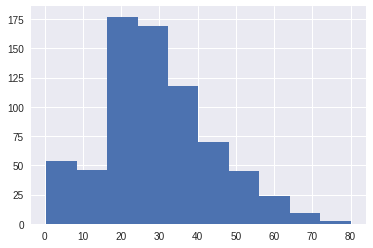

In [416]:
train_df['Age'].hist()

In [417]:
# There are 177 null values, practically 1/4 of the dataset have nan ages!
print('Count:', train_df['Age'].count())
print('Null count:', train_df['Age'].isnull().sum())
print(train_df['Age'].isnull().sum() / train_df['Age'].count() * 100,'% of ages are NAN', sep="")

Count: 714
Null count: 177
24.7899159664% of ages are NAN


In [418]:
# Let's fix that, by using mean and standart deviation together

In [419]:
age_mean = train_df['Age'].mean()
age_std = train_df['Age'].std()
age_nan_count = train_df['Age'].isnull().count()

In [420]:
age_mean, age_std, age_nan_count

(29.69911764705882, 14.526497332334042, 891)

In [421]:
rand_ages = np.random.randint(age_mean - age_std, age_mean + age_std, age_nan_count)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


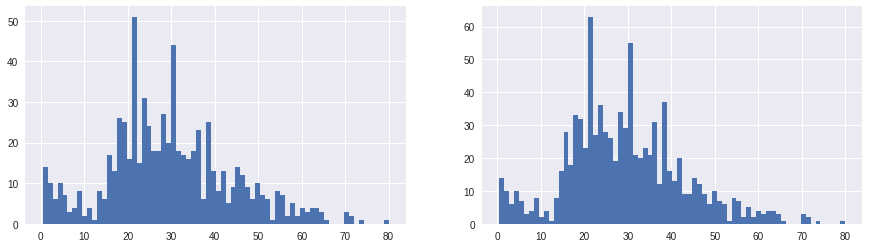

In [422]:
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(15,4))
axis1.set_title = 'Original values of ages'
axis2.set_title = 'New values of ages'

# Original values without NAN
train_df['Age'].dropna().astype(float).hist(bins=70, ax=axis1)

# New values with random ages
train_df['Age'][np.isnan(train_df['Age'])] = rand_ages
train_df['Age'].hist(bins=70, ax=axis2)

In [423]:
print('Now there are {} null values!'.format( train_df['Age'].isnull().sum()) )

Now there are 0 null values!


#### Transforming age from continuous to categorical values

The hist() function brought to us, 8 bins on the 'Age' column, transforming our continuous values to 8 categorial values. Let's test this by comparing the relation of these new values to survived

In [424]:
train_df['AgeCategorical'] = pd.cut(train_df['Age'], bins=8)
train_df['AgeCategorical'].value_counts()

relation_age_survived = train_df[['AgeCategorical', 'Survived']].groupby('AgeCategorical', as_index=False).mean()

Plotting the results, is visible that children between 0 and 10 years are most likely to survive

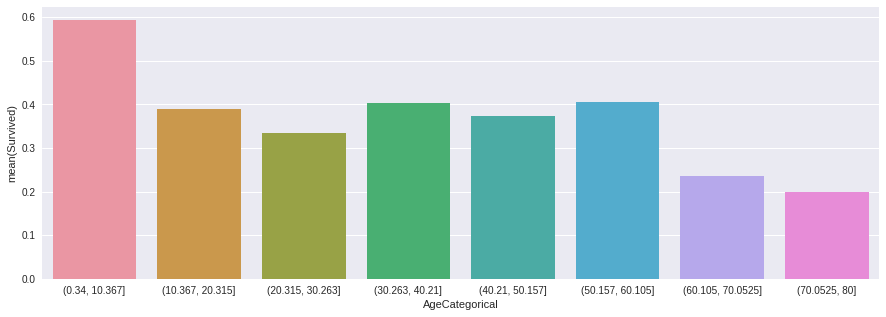

In [425]:
fig, axis1 = plt.subplots(1,1,figsize=(15,5))
sns.barplot(x='AgeCategorical',y='Survived', data=relation_age_survived)

In [426]:
train_df.loc[train_df['Age'] < 10.367, 'Age'] = 0
train_df.loc[(train_df['Age'] >= 10.367) & (train_df['Age'] < 20.315), 'Age'] = 1
train_df.loc[(train_df['Age'] >= 20.315) & (train_df['Age'] < 30.263), 'Age'] = 2
train_df.loc[(train_df['Age'] >= 30.263) & (train_df['Age'] < 40.21), 'Age'] = 3
train_df.loc[(train_df['Age'] >= 40.21) & (train_df['Age'] < 50.157), 'Age'] = 4
train_df.loc[(train_df['Age'] >= 50.157) & (train_df['Age'] < 60.105), 'Age'] = 5
train_df.loc[(train_df['Age'] >= 60.105) & (train_df['Age'] < 70.0525), 'Age'] = 6
train_df.loc[(train_df['Age'] >= 70.0525) & (train_df['Age'] < 80), 'Age'] = 7

train_df['Age'] = train_df['Age'].astype(int)

# AgeCategorical isn't necessary anymore
train_df.drop('AgeCategorical', 1, inplace=True)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,2,1,0,7.2500,S
1,1,1,female,3,1,0,71.2833,C
2,1,3,female,2,0,0,7.9250,S
3,1,1,female,3,1,0,53.1000,S
4,0,3,male,3,0,0,8.0500,S


#### SIBSP, PARCH (FAMILY)

Both sibsp and parch are related to the number of family members are with the passanger:

<i>sibsp: The dataset defines family relations in this way...<br/>
Sibling = brother, sister, stepbrother, stepsister<br/>
Spouse = husband, wife (mistresses and fiancés were ignored)<br/>

parch: The dataset defines family relations in this way...<br/>
Parent = mother, father<br/>
Child = daughter, son, stepdaughter, stepson<br/>
Some children travelled only with a nanny, therefore parch=0 for them.</i>

Let's fuse these two columns, so we can reduce dimensionally our dataset

In [427]:
train_df['Family'] = train_df['SibSp'] + train_df['Parch']
train_df.drop(['SibSp','Parch'], 1, inplace=True)

In [428]:
train_df[['Family','Survived']].groupby('Family', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Family,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


Let's create another feature, to see if the passenger is alone.

In [429]:
train_df['Alone'] = train_df['Family'].copy()
train_df['Alone'].loc[train_df['Alone'] > 0] = 1
train_df['Alone'].loc[train_df['Alone'] == 0] = 0

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [430]:
relation_alone_survived = train_df[['Alone','Survived']].groupby('Alone', as_index=False).mean()\
.sort_values(by='Alone', ascending=False)

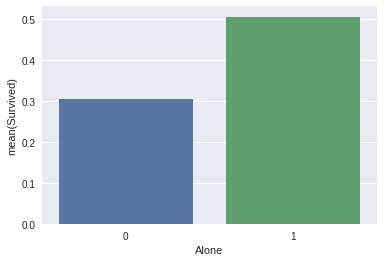

In [431]:
sns.barplot(x='Alone', y='Survived', data=relation_alone_survived)

 We can use the new feature 'Alone' for prediction, instead of the 'Family' size.  Maybe that could be explained, if we think that people who doesn't have any family member aboard, only had themselves to worry about. On the other hand, people who had family members in the ship, would think about saving their loved ones like children, spouse, etc

In [432]:
train_df.drop('Family', 1, inplace=True)
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Alone
0,0,3,male,2,7.2500,S,1
1,1,1,female,3,71.2833,C,1
2,1,3,female,2,7.9250,S,0
3,1,1,female,3,53.1000,S,1
4,0,3,male,3,8.0500,S,0


#### EMBARKED

The embarked feature, is about the port of embarkation: <br/>
C = Cherbourg<br/>
Q = Queenstown<br/>
S = Southampton<br/>


As we saw earlier, Embarked have two null values that we need to fix:

In [433]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
Alone       891 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 48.8+ KB


In [434]:
print('There are {} null values in Embarked'.format(train_df['Embarked'].isnull().sum()))

#Seeing the values
train_df['Embarked'].value_counts()

There are 2 null values in Embarked


S    644
C    168
Q     77
Name: Embarked, dtype: int64

We'll set the most common value for those null values

In [435]:
embarked_most_common = train_df['Embarked'].value_counts().idxmax()
train_df['Embarked'].fillna(embarked_most_common, inplace=True)

print('Now there are {} null values in Embarked'.format(train_df['Embarked'].isnull().sum()))

Now there are 0 null values in Embarked


In [436]:
train_df[['Embarked','Survived']].groupby('Embarked', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [437]:
train_df['Embarked'] = train_df['Embarked'].map({'S': 0, 'Q': 1, 'C': 2}).astype(int)

Embarked is ready for prediction!

#### FARE

'Fare' has a null value in the test set. We'll give to it the median value of the column

In [438]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 26.2+ KB


In [439]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

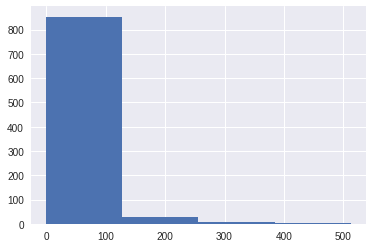

In [440]:
train_df['Fare'].hist(bins=4)

<bound method Grid.add_legend of <seaborn.axisgrid.FacetGrid object at 0x7f327fcda898>>

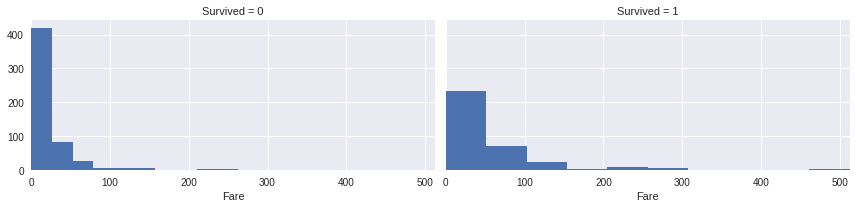

In [441]:
facet = sns.FacetGrid(train_df, col='Survived', aspect=2)
facet.map(plt.hist, 'Fare')
facet.set(xlim=(0, train_df['Fare'].max()))
facet.add_legend

Since we have a lot of fare with low values and just a few with high values, let's divide categorically using qcut, that's going to considerate this fact for separing values  

In [442]:
train_df['FareCategorical'] = pd.qcut(train_df['Fare'], 4)
train_df['FareCategorical'].value_counts()

(7.91, 14.454]    224
[0, 7.91]         223
(31, 512.329]     222
(14.454, 31]      222
Name: FareCategorical, dtype: int64

In [443]:
train_df[['FareCategorical','Survived']].groupby('FareCategorical', as_index=False).mean().\
sort_values(by='Survived',ascending=False)

,FareCategorical,Survived
3,"(31, 512.329]",0.581081
2,"(14.454, 31]",0.454955
1,"(7.91, 14.454]",0.303571
0,"[0, 7.91]",0.197309


In [444]:
train_df.loc[train_df['Fare'] < 7.91, 'Fare'] = 0
train_df.loc[(train_df['Fare'] >= 7.91) & (train_df['Fare'] < 14.454), 'Fare'] = 1
train_df.loc[(train_df['Fare'] >= 14.454) & (train_df['Fare'] < 31), 'Fare'] = 2
train_df.loc[train_df['Fare'] >= 31, 'Fare'] = 3

train_df['Fare'] = train_df['Fare'].astype(int)
train_df.drop('FareCategorical', 1, inplace=True)

In [445]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Alone
0,0,3,male,2,0,0,1
1,1,1,female,3,3,2,1
2,1,3,female,2,1,0,0
3,1,1,female,3,3,0,1
4,0,3,male,3,1,0,0
